# Introductory tutorial for PASTAQ DDA data exploration and processing
## Load pastaq and raw data
This tutorial shows the basic functionality of PASTAQ library provided by python binding.

First load pastaq as well other packages for visualisation and some basic data analysis. Then load the LC-MS(/MS) file in mzML or mzXML format using the `read_mzml` or `read_mzxml` function. Set the average full width at half maximum (`avg_fwhm_rt`) of the chromatographic peak. Then load the default parameters for Orbitrap using `default_parameters` function and change required parameters (in this case MS2 resolution).

In [11]:
import pastaq as pq
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from helpers import interpolate_values, find_closest_peak, plot_gaussian

# file name and location of the example file
exampleFile1 = "/mnt/e/data/projects/pastaqtesting/testData/3_1_extract_3400_4100_590_615.mzML"
exampleFile2 = "/mnt/e/data/projects/pastaqtesting/testData/3_2_extract_3400_4100_590_615.mzML"
avg_fwhm_rt = 25 # default 15

# load example file
lcmsData1 = pq.read_mzml(file_name = exampleFile1, min_mz = -1, max_mz = -1, min_rt = -1, max_rt = -1, instrument_type = 'ORBITRAP', resolution_ms1 = 70000, resolution_msn = 17500, reference_mz = 200, fwhm_rt = avg_fwhm_rt, polarity = '+', ms_level = 1)
lcmsDataMS2_1 = pq.read_mzml(file_name = exampleFile1, min_mz = -1, max_mz = -1, min_rt = -1, max_rt = -1, instrument_type = 'ORBITRAP', resolution_ms1 = 70000, resolution_msn = 17500, reference_mz = 200, fwhm_rt = avg_fwhm_rt, polarity = '+', ms_level = 2)
lcmsData2 = pq.read_mzml(file_name = exampleFile2, min_mz = -1, max_mz = -1, min_rt = -1, max_rt = -1, instrument_type = 'ORBITRAP', resolution_ms1 = 70000, resolution_msn = 17500, reference_mz = 200, fwhm_rt = avg_fwhm_rt, polarity = '+', ms_level = 1)
lcmsDataMS2_2 = pq.read_mzml(file_name = exampleFile2, min_mz = -1, max_mz = -1, min_rt = -1, max_rt = -1, instrument_type = 'ORBITRAP', resolution_ms1 = 70000, resolution_msn = 17500, reference_mz = 200, fwhm_rt = avg_fwhm_rt, polarity = '+', ms_level = 2)
params = pq.default_parameters(instrument = 'orbitrap', avg_fwhm_rt = avg_fwhm_rt)
params['resolution_msn'] = 17500
print(params)

{'instrument_type': 'orbitrap', 'resolution_ms1': 70000, 'resolution_msn': 17500, 'reference_mz': 200, 'avg_fwhm_rt': 25, 'num_samples_mz': 5, 'num_samples_rt': 5, 'smoothing_coefficient_mz': 0.4, 'smoothing_coefficient_rt': 0.4, 'warp2d_slack': 30, 'warp2d_window_size': 100, 'warp2d_num_points': 2000, 'warp2d_rt_expand_factor': 0.2, 'warp2d_peaks_per_window': 100, 'metamatch_fraction': 0.7, 'metamatch_n_sig_mz': 1.5, 'metamatch_n_sig_rt': 1.5, 'feature_detection_charge_states': [5, 4, 3, 2, 1], 'max_peaks': 1000000, 'polarity': 'both', 'min_mz': 0, 'max_mz': 100000, 'min_rt': 0, 'max_rt': 100000, 'link_n_sig_mz': 3, 'link_n_sig_rt': 3, 'ident_max_rank_only': True, 'ident_require_threshold': True, 'ident_ignore_decoy': True, 'similarity_num_peaks': 2000, 'qc_plot_palette': 'husl', 'qc_plot_extension': 'png', 'qc_plot_fill_alpha': 'dynamic', 'qc_plot_line_alpha': 0.5, 'qc_plot_scatter_alpha': 0.3, 'qc_plot_scatter_size': 2, 'qc_plot_min_dynamic_alpha': 0.1, 'qc_plot_per_file': False, 'q

Print the main characteristics of LC-MS(/MS) data and the first 20 intensities of the MS1 spectra with id of 20.

Main characteristics of LCMS data:
 <bound method PyCapsule.dump of RawData:
> instrument_type: ORBITRAP
> resolution_ms1: 70000.000000
> resolution_msn: 17500.000000
> reference_mz: 200.000000
> min_mz: 590.000099
> max_mz: 614.999939
> min_rt: 3400.143000
> max_rt: 4098.910680
> number of scans: 879> 

First 20 intensity of scan  10 :
 [123137.6640625, 198857.796875, 186504.703125, 110450.796875, 30861.353515625, 51615.1875, 93108.640625, 108093.6484375, 77396.5, 24463.44921875, 29560.482421875, 76585.5234375, 94415.8671875, 70456.1171875, 33264.14453125, 54325.26953125, 121243.7578125, 180292.203125, 110860.3984375]


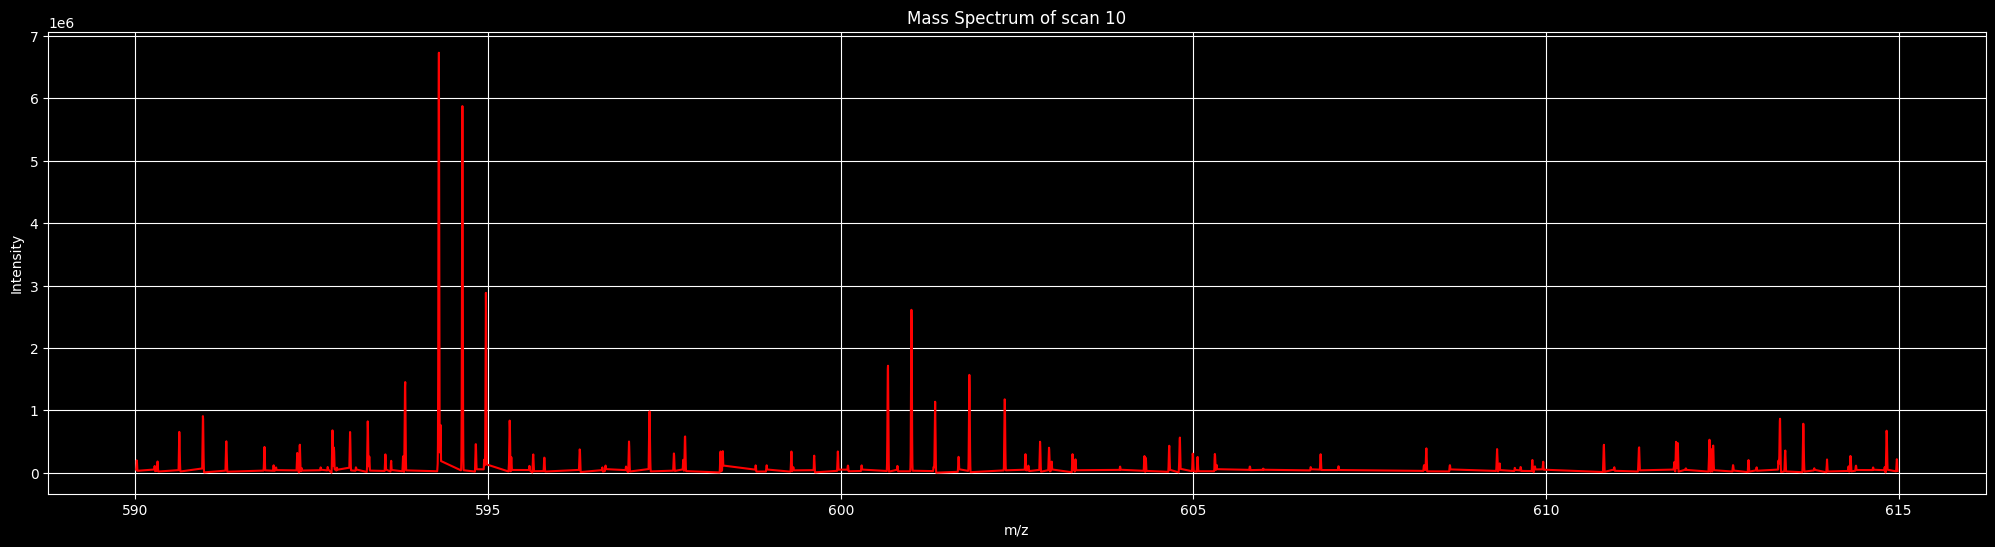

In [12]:
scanIdx = 10
print('Main characteristics of LCMS data:\n', lcmsData1.dump, '\n')
# print('Main properties of an LCMS scan:\n', dir(lcmsData1.scans[scanIdx]), '\n')
print('First 20 intensity of scan ', scanIdx, ':\n', lcmsData1.scans[scanIdx].intensity[1:20])

# plot the mass spectra of scan 10
plt.figure(figsize=(25, 6))  # Set the figure size
plt.plot(lcmsData1.scans[scanIdx].mz, lcmsData1.scans[scanIdx].intensity, color = 'red', marker='', linestyle='-')  # Plot mz vs. intensity
plt.xlabel('m/z')  # Set the x-axis label
plt.ylabel('Intensity')  # Set the y-axis label
plt.title('Mass Spectrum of scan {}' .format(scanIdx))  # Set the title
plt.grid(True)  # Show grid
plt.show()  # Show the plot

In [13]:
print(dir(pq))
# help(pq.resample)

['DBSequence', 'Feature', 'FeatureCluster', 'FeatureId', 'Grid', 'IdentData', 'InferredProtein', 'Instrument', 'LinkedMsms', 'LinkedPsm', 'Peak', 'PeakCluster', 'PeakId', 'Peptide', 'PeptideEvidence', 'PeptideModification', 'Polarity', 'PrecursorInformation', 'RawData', 'RawPoints', 'Scan', 'Similarity', 'SpectrumMatch', 'TimeMap', 'Xic', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_custom_log', 'calculate_similarity_matrix', 'calculate_time_map', 'colors', 'create_quantitative_tables', 'datetime', 'dda_pipeline', 'dda_pipeline_summary', 'default_parameters', 'detect_features', 'detect_peaks', 'find_feature_clusters', 'find_peak_clusters', 'find_peaks', 'find_protein_groups', 'find_sequence_consensus', 'find_similarity', 'generate_qc_plots', 'gridspec', 'json', 'link_idents', 'link_peaks', 'link_peaks_msms_idents', 'link_psm', 'logging', 'match_peaks_and_features', 'np', 'os', 'parse_mzidentml_files', 'parse_raw

## Perform smoothing and resampling of MS1 data using 2D Gaussian kernel density
- Perform the smoothing with `resample` function.
- Plot the smooth and resampled data as heatmap showing TIC and spectra sum with the `plot_mesh` function.

The similar peak patter and the 120 second retention time shift are visible on the smooth figure.

First dataset


{'img_plot': <Axes: xlabel='m/z', ylabel='retention time (s)'>,
 'mz_plot': <Axes: ylabel='Intensity'>,
 'rt_plot': <Axes: xlabel='Intensity'>}

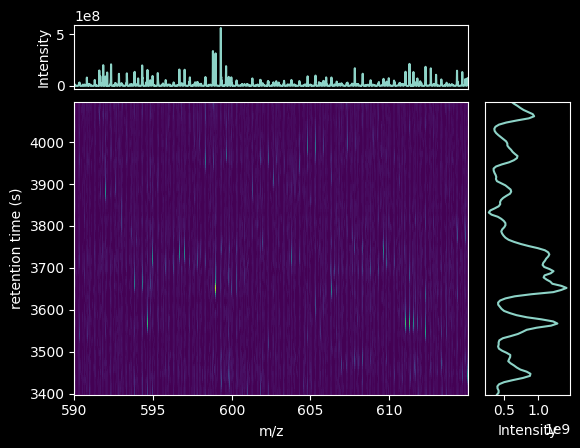

In [14]:
grid1 = pq.resample(lcmsData1, params['num_samples_mz'], params['num_samples_rt'], params['smoothing_coefficient_mz'], params['smoothing_coefficient_rt'])
grid2 = pq.resample(lcmsData2, params['num_samples_mz'], params['num_samples_rt'], params['smoothing_coefficient_mz'], params['smoothing_coefficient_rt'])

# plot the smoothed LC-MS map for dataset 1
print('First dataset')
pq.plot_mesh(grid1, transform='sqrt', figure=None)

Second dataset


{'img_plot': <Axes: xlabel='m/z', ylabel='retention time (s)'>,
 'mz_plot': <Axes: ylabel='Intensity'>,
 'rt_plot': <Axes: xlabel='Intensity'>}

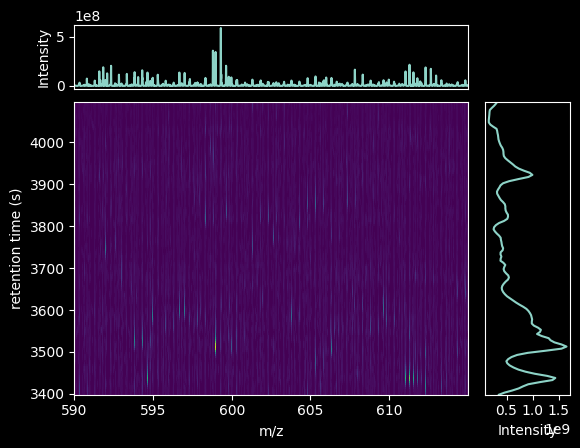

In [15]:
# plot the smoothed LC-MS map for dataset 2
print('Second dataset')
pq.plot_mesh(grid2, transform='sqrt', figure=None)

## Peak detection of isotopologue in form of 2D Gaussian peak and visualisation of detected peak.
Peak detection using fast 2D Gaussian fitting to local maxima identified in 2D kernel density smoothed LC-MS map using `find_peaks` function requiring raw data, the 2D kernel density LC-MS map and maximum number of detected peaks (the number of reported peaks may be lower than the value provided here). Printing the first (most abundant) peak from peak list of both files.<br>

Extracted ion chromatogram showing maximum intensity is ploted with the `plot_xic` function.

Plot the raw data points as well as TIC and sumed spectra of peak with index 20 using `plot_peak_raw_points` function.

Peak <id: 0, local_max_mz: 598.969421, local_max_rt: 3654.694083, local_max_height: 48604413.414760, fitted_height: 64467671.670919, fitted_mz: 598.970156, fitted_rt: 3653.005007, fitted_sigma_mz: 0.005523, fitted_sigma_rt: 9.542328, fitted_volume: 21349410.526087>
Peak <id: 0, local_max_mz: 599.304356, local_max_rt: 3515.300296, local_max_height: 58808916.485232, fitted_height: 67259702.463243, fitted_mz: 599.303816, fitted_rt: 3516.811830, fitted_sigma_mz: 0.005471, fitted_sigma_rt: 12.973675, fitted_volume: 29996968.902009>


{'img_plot': <Axes: >,
 'mz_plot': <Axes: ylabel='Intensity'>,
 'rt_plot': <Axes: xlabel='Intensity'>}

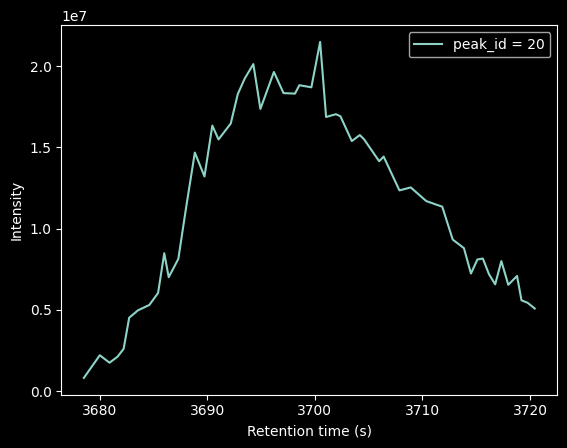

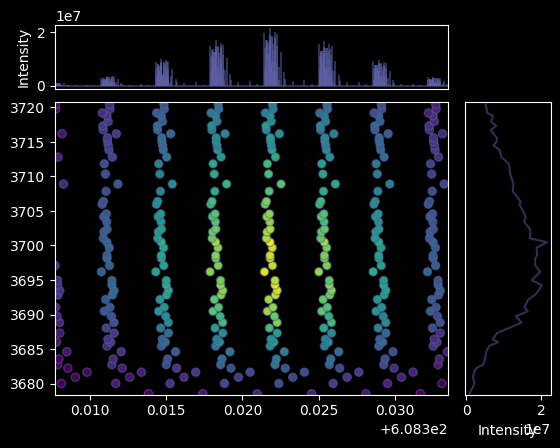

In [16]:
peaks1 = pq.find_peaks(lcmsData1, grid1, params['max_peaks'])
peaks2 = pq.find_peaks(lcmsData2, grid2, params['max_peaks'])

print(peaks1[0])
print(peaks2[0])

# plot the EIC of the peak with index 20.
fill_alpha = params['qc_plot_fill_alpha']
line_alpha = params['qc_plot_line_alpha']
scatter_alpha = params['qc_plot_scatter_alpha']
palette = sns.color_palette(params['qc_plot_palette'], 10)
pq.plot_xic(peaks1[20], lcmsData1, figure=None, method="max")

# plot the peak raw points with TIC in total ion spectra
pq.plot_peak_raw_points(peaks1[20], lcmsData1, img_plot=None, rt_plot=None, mz_plot=None, xic_method="max")

## Visulisation of raw data EIC, smoothed map and peak location of a peak with a given index
First limits for mz width with given a number of sigma is calculated as well the retention time window. With this limits the `pq.xic` function provide extraction ion chromatogram between two limits of mz and retention time. Next limits from the smoothed LC-MS1 map using the previous mz range, EIC trace is calculated and visualised. Then location of the peak is prvovided by a vertical green line and the fitted Gaussian of the peak is visualised.

You can set the variable `peakIdx` to various values invoking different peaks. Since peaks are sorted according to intensity, index 0 refers to the larger and the last index refers to the lowest abundant peak. You can play by setting the variable `sigmaFactor`, which set the width of EICs in numbers of fitted mz sigma of the Gaussian peak. A value of 0.25 gives more or less local intensity, and the value of 1 give larger range and less noise raw data EIC.


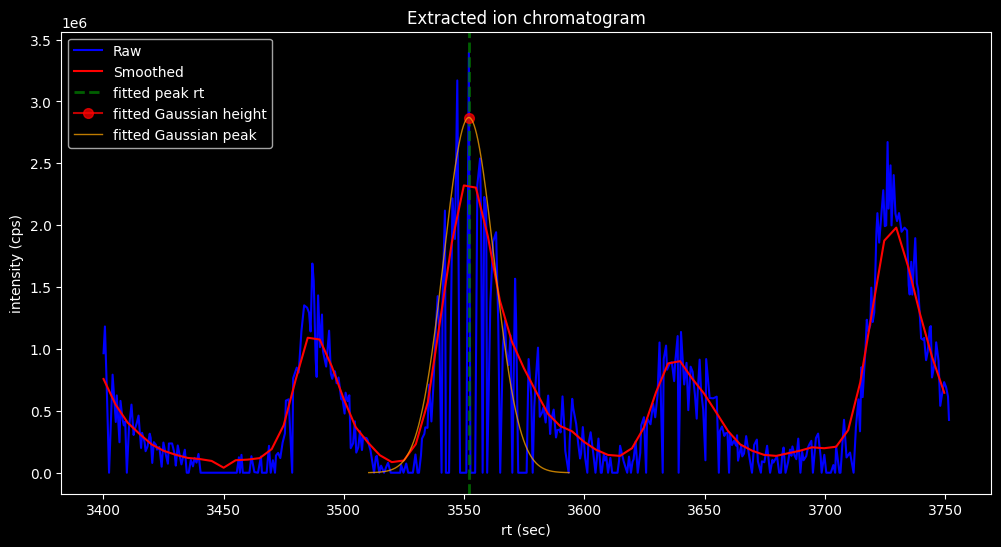

In [17]:
peakIdx = 155
sigmFactor = 0.25 #0.25 gives more or less local intensity, 1 give larger range and less noise raw data EIC

lowBoundmz = peaks1[peakIdx].fitted_mz-sigmFactor*peaks1[peakIdx].fitted_sigma_mz
highBoundmz = peaks1[peakIdx].fitted_mz+sigmFactor*peaks1[peakIdx].fitted_sigma_mz
lowBoundrt = peaks1[peakIdx].fitted_rt-200
highBoundrt = peaks1[peakIdx].fitted_rt+200
xic1 = pq.xic(lcmsData1, lowBoundmz, highBoundmz, lowBoundrt, highBoundrt)

np.array(grid1.bins_mz, dtype=np.float64)
indices_mz1 = [i for i, val in enumerate(np.array(grid1.bins_mz, dtype=np.float64)) if lowBoundmz < val < highBoundmz]
indices_rt1 = [i for i, val in enumerate(np.array(grid1.bins_rt, dtype=np.float64)) if lowBoundrt < val < highBoundrt]
xicGrid = np.array(grid1.data).reshape(grid1.m, grid1.n)
xicGridi1 = xicGrid[indices_rt1][:, indices_mz1]
xicGridis1 = np.sum(xicGridi1, axis=1)
xicGridrt1 = np.array(grid1.bins_rt, dtype=np.float64)[indices_rt1]

plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(xic1.retention_time, xic1.intensity, label='Raw', alpha=1, color='blue')
plt.plot(xicGridrt1, xicGridis1, label='Smoothed', alpha=1, color='red')
plt.axvline(x=peaks1[peakIdx].fitted_rt, label='fitted peak rt', color='green', alpha=0.75, linestyle='--', linewidth=2)
plt.plot(peaks1[peakIdx].fitted_rt, peaks1[peakIdx].fitted_height, label='fitted Gaussian height', marker='o', markersize=7, color='red', alpha=0.75)

# Plot the Gaussian peak
plot_gaussian(peaks1[peakIdx].fitted_rt, peaks1[peakIdx].fitted_sigma_rt, peaks1[peakIdx].fitted_height)

plt.xlabel('rt (sec)')
plt.ylabel('intensity (cps)')
plt.title('Extracted ion chromatogram')
plt.legend()

# show the plot
plt.show()

## Feature detection and linking MS/MS to MS1 peaks
First features (isotope clusters are detected) using the averaging model. This is followed by showing the characteristics of the first isotope cluster for both example datasets.

Then MS/MS events are linked to the peaks using proximity expressed in number of sigma. This is followed by showing the characteristics of the first isotope cluster for both example datasets. Using the linked MS/MS event to peaks and the linked peaks (isotopologues) in features it is possible to get MS/MS linked to features. Linking identification results to MS/MS events allow to study the consistency of identification in DDA experiments.

In [18]:
# detecting features
features1 = pq.detect_features(peaks1, params['feature_detection_charge_states'])
features2 = pq.detect_features(peaks2, params['feature_detection_charge_states'])
print("First isotope cluster (feature) in dataset 1:", features1[0])
print("First isotope cluster (feature) in dataset 2:", features2[0])

# linking MS/MS events to peaks.
linked_msms1 = pq.link_peaks(peaks1, lcmsDataMS2_1, params['link_n_sig_mz'], params['link_n_sig_rt'])
linked_msms2 = pq.link_peaks(peaks2, lcmsDataMS2_2, params['link_n_sig_mz'], params['link_n_sig_rt'])
print("First linked MS/MS event in dataset 1:", linked_msms1[0])
print("First linked MS/MS event in dataset 1:", linked_msms2[0])

First isotope cluster (feature) in dataset 1: Feature <id: 0, average_rt: 3653.788129, average_mz: 599.325806, total_height: 176476145.747553, monoisotopic_mz: 598.970156, monoisotopic_height: 64467671.670919, charge_state: 3, n_isotopes: 7>
First isotope cluster (feature) in dataset 2: Feature <id: 0, average_rt: 3515.571494, average_mz: 599.328879, total_height: 189580918.037741, monoisotopic_mz: 598.969689, monoisotopic_height: 67078702.311875, charge_state: 3, n_isotopes: 7>
First linked MS/MS event in dataset 1: LinkedMsms <entity_id: 0, scan_index: 103, msms_id: 391, distance: 2.201093>
First linked MS/MS event in dataset 1: LinkedMsms <entity_id: 0, scan_index: 47, msms_id: 196, distance: 0.593648>


## Time alignment of two LC-MS map
First time map holding the piece-wise alignment map between two peaks list is calculated is performed using `calculate_time_map` function. The first is the reference and the second peak list is the sample. The first parameter refers to the slack defining the number of points allowed to move at one particular segment end, the second parameter provides the segment length in points, the third parameters provide the number of points considered for the whole chromatogram (this parameter divided by the previous give the number of segments used in the alignment process), the fourth parameters provide the extension factor of the chromatogram, which is useful for aligning data, which does not have an empty region at the beginning and end of the chromatogram. The last parameter is the number of most abundant peaks considered to calculate overlap driving the alignment process. Then the retention time of the sample peak list is changed according to the time map function using the `warp_peaks` function. Then similarity between original two peak lists and the reference and the aligned sample peak list is calculated using `find_similarity` function.
The small value of the similarity score show large shift between dataset 1 and 2, which have been successfully corrected as indicated to a similarity score close to 1 after alignment. Try to play with the parameter to assess how it affect overall similarity of LC-MS/MS map after alignment.

In [19]:
# calculate alignment time map (piece-wise linear alignment function) between peak1 (not altered and used as reference) and peak2 (sample peak list, which will change retention time)
time_map_1r_2s = pq.calculate_time_map(peaks1, peaks2, 5, 10, 500, 0.2, 20)

# align peaks2 to peaks1 using the calculated time map
peaks2_1r = pq.warp_peaks(peaks2, time_map_1r_2s)

# calculate similarity matrix before and after warping between peak list 1 and 2
print("Raw data similarity: {:.5f}".format(pq.find_similarity(peaks1, peaks2,params['similarity_num_peaks']).geometric_ratio))
print("Similarity after alignment: {:.5f}".format(pq.find_similarity(peaks1, peaks2_1r,params['similarity_num_peaks']).geometric_ratio))

Raw data similarity: 0.07085
Similarity after alignment: 0.87343


## Showing the effect of alignment on the original and aligned EIC of a peak in dataset 2 matched to a reference peak in dataset 1.
This plot shows the reference EIC for the peak selected using `peakIdx` variable above as blue trace in dataset 1, with the EIC of the matched peak in the raw (red) and aligned (green) datase 2. The dots corresponding to the reference peak (dataset 1 in blue), the matched peaks in dataset 2 in the raw data (red) and after alignment (green) is shown on the plot. The `interpolate_value` function available in `helpers.py` interpolate the retention time values of EIC, which allows to visualise the EIC in dataset 2 aligned aligned to the retention time of dataset 1.

Raw data similarity: {}Peak <id: 155, local_max_mz: 614.838085, local_max_rt: 3549.878931, local_max_height: 2320983.763784, fitted_height: 2869797.871078, fitted_mz: 614.838210, fitted_rt: 3551.959701, fitted_sigma_mz: 0.005780, fitted_sigma_rt: 10.402839, fitted_volume: 1084166.580670>
Raw data similarity: {}Peak <id: 112, local_max_mz: 614.838226, local_max_rt: 3420.423585, warped_rt: 3549.585229 (129.161644), local_max_height: 2545291.369142, fitted_height: 3107350.906077, fitted_mz: 614.837770, fitted_rt: 3422.614966, fitted_sigma_mz: 0.005834, fitted_sigma_rt: 10.202981, fitted_volume: 1162086.455774>


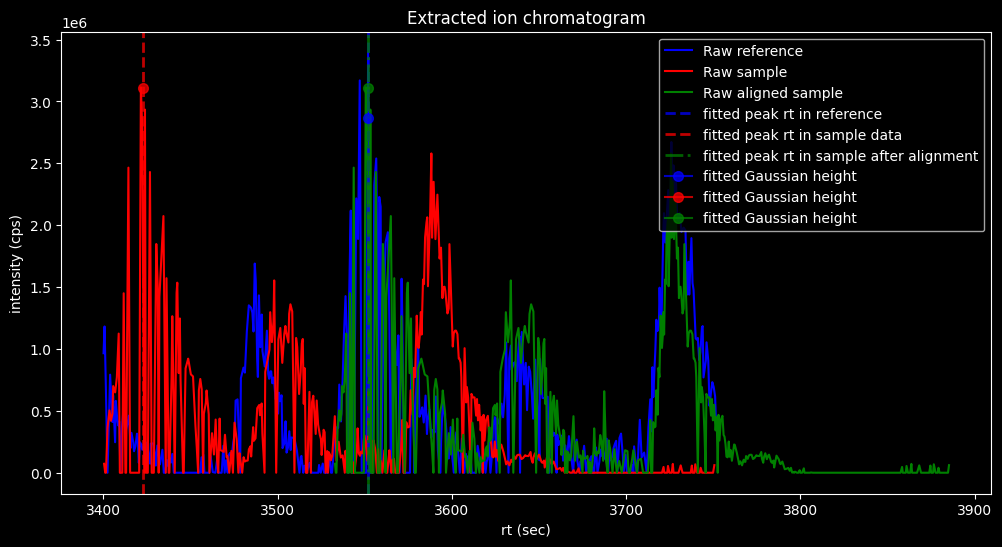

In [20]:
# get extracted ion chromatogram for file 2 using the same mz and rt range as for file 1
xic2 = pq.xic(lcmsData2, lowBoundmz, highBoundmz, lowBoundrt, highBoundrt)

# get matching peak for peaks1[peakIdx] in peaks2_1r
matchedpeak = find_closest_peak(peaks1[peakIdx], peaks2_1r)

# print target peaks and matched peaks in the other chromatograms
print("Raw data similarity: {}" + format(peaks1[peakIdx]))
print("Raw data similarity: {}" + format(matchedpeak))

alignedRTs = interpolate_values(xic2.retention_time, time_map_1r_2s.sample_rt_start, time_map_1r_2s.sample_rt_end, time_map_1r_2s.rt_start, time_map_1r_2s.rt_end)

#plot the raw EIC in the reference (blue) and sample data (red), and the aligned EIC in the sample data (green)
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(xic1.retention_time, xic1.intensity, label='Raw reference', alpha=1, color='blue')
plt.plot(xic2.retention_time, xic2.intensity, label='Raw sample', alpha=1, color='red')
plt.plot(alignedRTs, xic2.intensity, label='Raw aligned sample', alpha=1, color='green')
plt.axvline(x = peaks1[peakIdx].fitted_rt, label='fitted peak rt in reference', color='blue', alpha=0.75, linestyle='--', linewidth=2)
plt.axvline(x = matchedpeak.fitted_rt, label='fitted peak rt in sample data', color='red', alpha=0.75, linestyle='--', linewidth=2)
plt.axvline(x = (matchedpeak.fitted_rt + matchedpeak.rt_delta), label='fitted peak rt in sample after alignment', color='green', alpha=0.75, linestyle='-.', linewidth=2)
plt.plot(peaks1[peakIdx].fitted_rt, peaks1[peakIdx].fitted_height, label='fitted Gaussian height', marker='o', markersize=7, color='blue', alpha=0.75)
plt.plot(matchedpeak.fitted_rt, matchedpeak.fitted_height, label='fitted Gaussian height', marker='o', markersize=7, color='red', alpha=0.75)
plt.plot((matchedpeak.fitted_rt + matchedpeak.rt_delta), matchedpeak.fitted_height, label='fitted Gaussian height', marker='o', markersize=7, color='green', alpha=0.75)

plt.xlabel('rt (sec)')
plt.ylabel('intensity (cps)')
plt.title('Extracted ion chromatogram')
plt.legend()

# show the plot
plt.show()